In [1]:
# 设置工作路径
import os
os.chdir("C:\\Users\\15068\\Python\\Online_network_calculator\\HCC_Immunotherapy")

# 获取并打印当前工作路径
current_path = os.getcwd()
print("当前工作路径:", current_path)

当前工作路径: C:\Users\15068\Python\Online_network_calculator\HCC_Immunotherapy


In [2]:
# ---------- 训练阶段：读取数据 + 网格搜索 + 保存模型 ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
import joblib

# 读取数据
df = pd.read_csv("HCC.csv")

In [3]:
# 目标变量
y = df["group"]
X = df.drop(["group"], axis=1)

# 划分训练集 / 测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=df["group"]
)

In [4]:
# XGBoost 基础参数
params_xgb = {
    "learning_rate": 0.02,
    "booster": "gbtree",
    "objective": "binary:logistic",
    "max_leaves": 127,
    "verbosity": 1,
    "seed": 42,
    "nthread": -1,
    "colsample_bytree": 0.6,
    "subsample": 0.7,
    "eval_metric": "logloss",
}

model_xgb = xgb.XGBClassifier(**params_xgb)

# 网格搜索参数
param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
}

grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring="neg_log_loss",
    cv=5,
    n_jobs=4,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best Log Loss score: ", -grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 200}
Best Log Loss score:  0.3689993855232749


              precision    recall  f1-score   support

           0       0.84      0.95      0.89        40
           1       0.33      0.12      0.18         8

    accuracy                           0.81        48
   macro avg       0.59      0.54      0.54        48
weighted avg       0.76      0.81      0.78        48



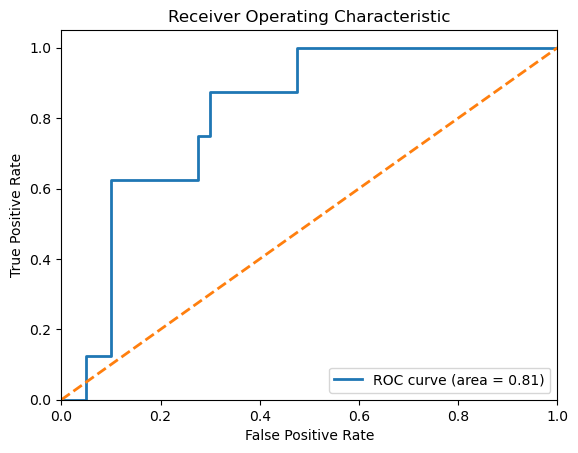

模型已保存：XGBoost.pkl


In [5]:
# 测试集评估
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC
y_score = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# 保存最优模型
joblib.dump(best_model, "XGBoost.pkl")
print("模型已保存：XGBoost.pkl")

In [7]:
# ==========================================================
# Streamlit APP：在线计算器（运行：streamlit run app.py）
# ==========================================================

import streamlit as st
import shap

MODEL_PATH = "XGBoost.pkl"
DATA_PATH = "HCC.csv"

@st.cache_resource
def load_model():
    return joblib.load(MODEL_PATH)

@st.cache_data
def load_data():
    return pd.read_csv(DATA_PATH)

model = load_model()
data = load_data()

# ✅ 特征名：影像9个 + 临床5个（更新）
feature_names = [
    # --- radiomics (9) ---
    "original_shape_Elongation_A",
    "log.sigma.1.0.mm.3D_glcm_Correlation_A",
    "lbp.3D.k_gldm_DependenceEntropy_A",
    "original_glcm_Autocorrelation",
    "original_gldm_LargeDependenceHighGrayLevelEmphasis",
    "log.sigma.1.0.mm.3D_firstorder_Median",
    "log.sigma.1.0.mm.3D_glrlm_ShortRunHighGrayLevelEmphasis",
    "wavelet.HHL_ngtdm_Complexity",
    "exponential_glcm_InverseVariance",

    # --- clinical (5) ---
    "Alcohol",
    "AFP",
    "AST_ALT",
    "Ascites",
    "ECOG_PS",
]

# 确保列存在
missing_cols = [c for c in feature_names if c not in data.columns]
if missing_cols:
    st.error(f"HCC.csv 缺少以下列：{missing_cols}")
    st.stop()

X_all = data[feature_names]
stats = X_all.agg(["min", "max", "median"])

# --------- helper：判断是否为0/1二分类 ---------
def is_binary_01(s: pd.Series) -> bool:
    vals = sorted(pd.Series(s.dropna().unique()).tolist())
    return len(vals) == 2 and vals == [0, 1]

# -----------------------------
# SHAP：TreeExplainer（适配XGBoost，速度快）
# -----------------------------
@st.cache_resource
def build_shap_explainer_tree(_model):
    return shap.TreeExplainer(_model)

explainer = build_shap_explainer_tree(model)

2026-02-20 16:03:44.442 No runtime found, using MemoryCacheStorageManager


In [8]:
# -----------------------------
# Streamlit 页面
# -----------------------------
st.title("HCC 疗效预测在线计算器（影像组学 + 临床联合模型）")

st.markdown("""
本工具基于机器学习模型，对肝细胞癌（HCC）患者进行**疗效（应答 vs 非应答）预测**。  
输入影像组学特征（Z-score）与临床变量（Alcohol、AFP、AST/ALT、Ascites、ECOG-PS）后，模型输出 **P(group=1，应答)** 的概率，并提供 SHAP 个体解释图。  
> ⚠️ 仅用于科研/教学，不能替代临床决策。
""")

st.subheader("1. 输入变量")
st.markdown("**（1）影像组学特征（已标准化的 Z-score 值）**")

input_values = {}

# radiomics 输入：min/max/median；step 0.01
radiomics_cols = [
    "original_shape_Elongation_A",
    "log.sigma.1.0.mm.3D_glcm_Correlation_A",
    "lbp.3D.k_gldm_DependenceEntropy_A",
    "original_glcm_Autocorrelation",
    "original_gldm_LargeDependenceHighGrayLevelEmphasis",
    "log.sigma.1.0.mm.3D_firstorder_Median",
    "log.sigma.1.0.mm.3D_glrlm_ShortRunHighGrayLevelEmphasis",
    "wavelet.HHL_ngtdm_Complexity",
    "exponential_glcm_InverseVariance",
]

for col in radiomics_cols:
    input_values[col] = st.number_input(
        label=f"{col}（标准化特征）",
        min_value=float(stats.loc["min", col]),
        max_value=float(stats.loc["max", col]),
        value=float(stats.loc["median", col]),
        step=0.01,
        format="%.4f",
    )

st.markdown("---")
st.markdown("**（2）临床特征**")

# Alcohol
if is_binary_01(data["Alcohol"]):
    input_values["Alcohol"] = st.selectbox(
        "Alcohol（饮酒史：0=无 / 1=有）",
        options=[0, 1],
        format_func=lambda x: "0 = 无饮酒史" if x == 0 else "1 = 有饮酒史",
    )
else:
    input_values["Alcohol"] = st.number_input(
        "Alcohol（数值编码）",
        min_value=float(stats.loc["min", "Alcohol"]),
        max_value=float(stats.loc["max", "Alcohol"]),
        value=float(stats.loc["median", "Alcohol"]),
        step=1.0,
    )

# AFP
input_values["AFP"] = st.number_input(
    "AFP（ng/mL）",
    min_value=float(stats.loc["min", "AFP"]),
    max_value=float(stats.loc["max", "AFP"]),
    value=float(stats.loc["median", "AFP"]),
    step=1.0,
)

# AST_ALT：可能连续比值或二分类
if is_binary_01(data["AST_ALT"]):
    input_values["AST_ALT"] = st.selectbox(
        "AST_ALT（0=低 / 1=高；按你研究截断后的变量）",
        options=[0, 1],
    )
else:
    input_values["AST_ALT"] = st.number_input(
        "AST/ALT（比值）",
        min_value=float(stats.loc["min", "AST_ALT"]),
        max_value=float(stats.loc["max", "AST_ALT"]),
        value=float(stats.loc["median", "AST_ALT"]),
        step=0.01,
        format="%.4f",
    )

# Ascites
if is_binary_01(data["Ascites"]):
    input_values["Ascites"] = st.selectbox(
        "Ascites（腹水：0=无 / 1=有）",
        options=[0, 1],
    )
else:
    asc_opts = sorted(pd.Series(data["Ascites"].dropna().unique()).tolist())
    input_values["Ascites"] = st.selectbox("Ascites（腹水分级/编码）", options=asc_opts)

# ECOG_PS
ecog_opts = sorted(pd.Series(data["ECOG_PS"].dropna().unique()).tolist())
input_values["ECOG_PS"] = st.selectbox("ECOG-PS", options=ecog_opts)

# 组装成模型输入（严格按 feature_names 顺序）
feature_values = [input_values[col] for col in feature_names]
features_df = pd.DataFrame([feature_values], columns=feature_names)

st.markdown("---")
st.subheader("2. 模型预测结果")

if st.button("点击进行预测"):
    # 预测类别与概率
    predicted_class = int(model.predict(features_df)[0])
    predicted_proba = model.predict_proba(features_df)[0]  # [p0, p1]

    prob_non_response = float(predicted_proba[0])  # group=0
    prob_response = float(predicted_proba[1])      # group=1

    st.write(f"**预测类别 (group)：{predicted_class}**")
    st.write("- group=0：多为“非应答/疗效不佳”（如 SD/PD）")
    st.write("- group=1：多为“应答/疗效较好”（如 CR/PR）")

    st.write("**预测概率（模型输出）**")
    st.write(f"- P(group = 0，非应答)：{prob_non_response * 100:.1f}%")
    st.write(f"- P(group = 1，应答)：{prob_response * 100:.1f}%")

    if predicted_class == 1:
        st.success(
            f"模型提示该患者**达到客观缓解（CR/PR）的概率较高**，"
            f"P(应答) ≈ {prob_response * 100:.1f}%。\n\n"
            "仅供科研参考，建议结合 MDT 综合判断。"
        )
    else:
        st.warning(
            f"模型提示该患者**达到客观缓解（CR/PR）的概率相对较低**，"
            f"P(应答) ≈ {prob_response * 100:.1f}%。\n\n"
            "仅供科研参考，建议结合随访与临床综合判断。"
        )

    st.markdown("---")
    st.subheader("3. 模型可解释性（SHAP 力图）")

    with st.spinner("正在计算 SHAP 值并生成图像..."):
        shap_values = explainer.shap_values(features_df)

        # 兼容二分类输出：可能是 list，也可能是 ndarray
        if isinstance(shap_values, list):
            shap_values_sample = shap_values[1][0]      # 阳性类（group=1）
            expected_value = explainer.expected_value[1]
        else:
            shap_values_sample = shap_values[0]
            expected_value = explainer.expected_value

        shap.initjs()
        plt.figure(figsize=(10, 3))
        shap.force_plot(
            expected_value,
            shap_values_sample,
            features_df,
            matplotlib=True,
            show=False,
        )
        plt.tight_layout()
        plt.savefig("shap_force_plot_hcc.png", bbox_inches="tight", dpi=300)
        plt.close()

    st.image("shap_force_plot_hcc.png", caption="当前患者的 SHAP 力图（特征对应答概率的贡献）")